In [169]:
import pytesseract
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
test_path = Path(r'D:\.VScode\SuperAI4\98-extra\ocr\test')
test_imgs = list(test_path.glob('*.png'))

In [229]:
config = r'--dpi 2400 --psm 7 --oem 3'

In [230]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [231]:
proposal_list = [
    [[60,80], [80,250]],
    [[90,140], [80,250]],
    [[100,140], [100,200]],
    [[110,130], [100,250]],
    [[120,150], [100,250]],
    [[100,120], [100,250]],
    [[85,120], [60,180]],#85:120,60:180
    [[120,140], [80,220]],
    [[130,160], [55,200]],
    [[70,90], [80,250]],
    [[110, 140], [80, 220]],
    [[85,120], [80, 200]]
]
numeric_list = ["๐", "๑", "๒", "๓", "๔", "๕", "๖", "๗", "๘", "๙"]


In [232]:
#create slider
def run(idx, img_i, plot = False):
    pos  = proposal_list[idx]
    # img =  cv2.imread(test_imgs[9])[120:140,80:220 :]
    img =  cv2.imread(test_imgs[img_i])[pos[0][0]:pos[0][1], pos[1][0]:pos[1][1], :]

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    generated_text = pytesseract.image_to_string(img, lang='tha', config = config)
    
    if plot:
        plt.imshow(img)
        print(generated_text) 
        plt.show()
    return generated_text
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

# interact(run, 
#          idx=widgets.IntSlider(min=0, max=len(proposal_list) - 1, step=1, value=0),
#          img_i=widgets.IntSlider(min=0, max=len(test_imgs) - 1, step=1, value=0));

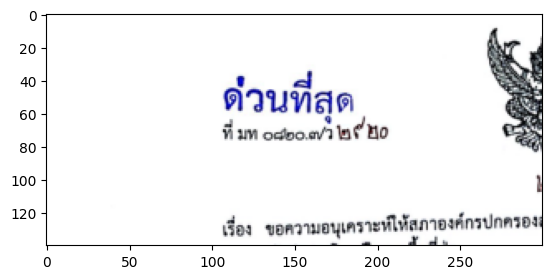

TesseractError: (1, "Error, unknown command line argument '--edges_min_nonhole'")

In [233]:
final_ans_list = []
for img in test_imgs:
    res_list = []
    plt.imshow(cv2.imread(img)[:140,:300 :])
    plt.show()
    for i in range(len(proposal_list)):
        res = run(i, img_i = test_imgs.index(img), plot = False)
        res_list.append(res)
        
    result = pd.DataFrame(res_list, columns=['text'])
    result["count"] =pd.DataFrame(res_list, columns=['text']).apply(lambda x: sum([1 for c in x['text'] if c in numeric_list]), axis=1)
    # get where max count row
    final_ans = result.loc[result['count'].idxmax(), "text"]
    print(final_ans)
    file_name = img.stem
    final_ans_list.append([file_name, final_ans])

In [223]:
thai_alphabet_to_thai_number = {
    'อ': '๖',  # Example mapping: 'อ' to '๖'
    'ศ': '๓',  # Example mapping: 'ศ' to '๓'
    'ษ': '๓',  # Example mapping: 'ษ' to '๓'
    '9': '๑',
    'ใ': '๒',
    
    '0': '๐',
    # Add more mappings as necessary
}

In [224]:
final_ans_pd = pd.DataFrame(final_ans_list, columns=['file_name', 'final_ans'])

#apply thai_alphabet_to_thai_number on each alphabet
final_ans_pd["final_ans"] = final_ans_pd["final_ans"].apply(lambda x: ''.join(thai_alphabet_to_thai_number.get(c, c) for c in x))

#remove all alphabet that not in numeric_list
import re
final_ans_pd["final_ans"] = final_ans_pd["final_ans"].apply(lambda x: re.sub("[^๐-๙]", "", x))

# map thai number to arabic number
thai_number_to_arabic_number = {
    '๐': '0',
    '๑': '1',
    '๒': '2',
    '๓': '3',
    '๔': '4',
    '๕': '5',
    '๖': '6',
    '๗': '7',
    '๘': '8',
    '๙': '9'
}
final_ans_pd["final_ans"] = final_ans_pd["final_ans"].apply(lambda x: ''.join(thai_number_to_arabic_number.get(c, c) for c in x))
final_ans_pd

#add - at the 4th position of the final_ans
final_ans_pd["final_ans"] = final_ans_pd["final_ans"].apply(lambda x: x[:4] + '-' + x[4:])

# submission

In [225]:
submission = pd.read_csv(r"D:\.VScode\SuperAI4\98-extra\ocr\working\sample_submission.csv")


In [226]:
for i, file_name in enumerate(final_ans_pd["file_name"]):
    submission.loc[(submission['id'] == file_name).values, 'pred'] = final_ans_pd.loc[i, "final_ans"]

In [227]:
submission.loc[0, "pred"] = "08084-2855"

In [228]:
submission.to_csv(r"D:\.VScode\SuperAI4\98-extra\ocr\working\submission.csv", index=False)